# Red Convolucional CarlosNet

## Descarga e importación del dataset

En este apartado hay un pequeño script que comprueba que el dataset no esté descargado o descomprimido para ahorrar tiempo en caso de que se esté probando otra de las redes incluidas en este proyecto.

El dataset se encuentra en: https://zenodo.org/record/3902223

In [1]:
import os
# Si se ejecuta desde google.colab: pip install wget
import wget
import zipfile
import sys

# Code from: https://stackoverflow.com/questions/58125279/python-wget-module-doesnt-show-progress-bar#answer-61346454        
def bar_progress(current, total, width=80):
  progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
  # Don't use print() as it will print in new line every time.
  sys.stdout.write("\r" + progress_message)
  sys.stdout.flush()

dataset_zip_filename = "dataset.zip"
dataset_folder = dataset_zip_filename.replace(".zip", "")
dataset_zip_url = "https://zenodo.org/record/3902223/files/dataset-single-hand-finger-count.zip"
if(not os.path.isfile(dataset_zip_filename)):
    print(f"Se descargará el dataset desde '{dataset_zip_url}'")
    #command_wget = f"wget --no-check-certificate -O {dataset_zip_filename} {dataset_zip_url}"
    wget.download(dataset_zip_url,dataset_zip_filename, bar=bar_progress)
    #command_wget_res = os.system(command_wget)
    if(os.path.isfile(dataset_zip_filename) and not os.path.exists(dataset_folder)):
        print(f"Dataset descargado con éxito en '{os.getcwd()}/{dataset_folder}'")
        zip_ref = zipfile.ZipFile(dataset_zip_filename, 'r')
        zip_ref.extractall(dataset_folder)
        zip_ref.close()
        print(f"El dataset se ha descomprimido en '{os.getcwd()}/{dataset_folder}'")
    
else:
    print(f"El archivo '{dataset_zip_filename}' ya existe en la carpeta '{os.getcwd()}' así que no se ha descargado.")
    if(not os.path.exists(dataset_folder)):
        print(f"El archivo {dataset_zip_filename} no parece haber sido descomprimido, se procede a descomprimir.")
        zip_ref = zipfile.ZipFile(dataset_zip_filename, 'r')
        zip_ref.extractall(dataset_folder)
        zip_ref.close()
        print(f"El archivo {dataset_zip_filename} se ha descromprimido con éxito en '{os.getcwd()}/{dataset_folder}'")
    else:
        print(f"El dataset está descomprimido en '{os.getcwd()}/{dataset_folder}'")

El archivo 'dataset.zip' ya existe en la carpeta '/home/carlos/projects/keras-cnn' así que no se ha descargado.
El dataset está descomprimido en '/home/carlos/projects/keras-cnn/dataset'


### Importación de los subonjuntos del dataset

Se importan cada uno de los subconjuntos en los que se divide el dataset.
Los valores de los canales de las imágenes pasan a ser del rango [0,255] a [0.0,1.0]. A su vez, reducimos el número de canales de color a 1 solo, dado que para este conjunto de datos las imágenes están en escala de grises y no es relevante tener más de un canal de color para representarlas.

Se establece en 30 el tamaño de los lotes de entrenamiento y en base a esto el número de pasos por época y validación.

In [6]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 30
simple_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_dir=f"{dataset_folder}/train"
test_dir=f"{dataset_folder}/test"
val_dir=f"{dataset_folder}/val"

train_set = simple_datagen.flow_from_directory(train_dir,
                  batch_size=batch_size,
                  class_mode='categorical',
                  target_size=(128, 128),
                  color_mode="grayscale")

test_set = simple_datagen.flow_from_directory(test_dir,
                  batch_size=batch_size,
                  class_mode = 'categorical',
                  target_size = (128, 128),
                  color_mode="grayscale")

val_set = simple_datagen.flow_from_directory(val_dir,
                  batch_size=batch_size,
                  class_mode = 'categorical',
                  target_size = (128, 128),
                  color_mode="grayscale")

Found 14400 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.


In [7]:
steps_per_epoch = train_set.n // batch_size
validation_steps = val_set.n // batch_size
print("Pasos por época: " + str(steps_per_epoch) + "    Pasos de validación: " + str(validation_steps))

Pasos por época: 480    Pasos de validación: 120


## CarlosNet (Sin data augmentation)

### Estructura de la red

El diseño de la arquitectura de esta red se ha enfocado en intentar diseñar una red lo más sencilla y con el menor número de parámetros posibles que permitiese un rendimiento óptimo para el dataset que se ha usado en este trabajo.

In [25]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(4,(3,3),activation='relu',input_shape=(128,128,1)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(8,(5,5),activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(16, (7,7), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 4)       40        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 42, 42, 4)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 38, 38, 8)         808       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 16)          6288      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 144)              

In [12]:
#### Introducir nombre del archivo que se va a guardar.
nombre_archivo = 'carlosNet-final'
# serializar el modelo a JSON
carlosnet_json = model.to_json()
with open(f"{nombre_archivo}.json", "w") as json_file:
    json_file.write(carlosnet_json)

### Entrenamiento del modelo

In [26]:

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(
             train_set,
             steps_per_epoch= steps_per_epoch,
             epochs=100,
             validation_data=val_set,
             validation_steps= validation_steps,
             verbose=2)

Epoch 1/100
480/480 - 22s - loss: 1.0610 - accuracy: 0.5936 - val_loss: 0.0714 - val_accuracy: 0.9825
Epoch 2/100
480/480 - 21s - loss: 0.1013 - accuracy: 0.9799 - val_loss: 0.0382 - val_accuracy: 0.9928
Epoch 3/100
480/480 - 21s - loss: 0.0193 - accuracy: 0.9958 - val_loss: 0.0119 - val_accuracy: 0.9983
Epoch 4/100
480/480 - 21s - loss: 0.0096 - accuracy: 0.9986 - val_loss: 0.0088 - val_accuracy: 0.9989
Epoch 5/100
480/480 - 21s - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.0071 - val_accuracy: 0.9981
Epoch 6/100
480/480 - 22s - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/100
480/480 - 22s - loss: 0.0030 - accuracy: 0.9999 - val_loss: 0.0028 - val_accuracy: 0.9997
Epoch 8/100
480/480 - 21s - loss: 0.0024 - accuracy: 0.9999 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 9/100
480/480 - 21s - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 10/100
480/480 - 21s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0018 - 

Epoch 76/100
480/480 - 22s - loss: 7.6417e-05 - accuracy: 1.0000 - val_loss: 9.1944e-05 - val_accuracy: 1.0000
Epoch 77/100
480/480 - 22s - loss: 7.5097e-05 - accuracy: 1.0000 - val_loss: 9.1146e-05 - val_accuracy: 1.0000
Epoch 78/100
480/480 - 21s - loss: 7.4157e-05 - accuracy: 1.0000 - val_loss: 9.6316e-05 - val_accuracy: 1.0000
Epoch 79/100
480/480 - 21s - loss: 7.2801e-05 - accuracy: 1.0000 - val_loss: 8.8748e-05 - val_accuracy: 1.0000
Epoch 80/100
480/480 - 21s - loss: 7.1110e-05 - accuracy: 1.0000 - val_loss: 9.7713e-05 - val_accuracy: 1.0000
Epoch 81/100
480/480 - 21s - loss: 7.1145e-05 - accuracy: 1.0000 - val_loss: 8.7455e-05 - val_accuracy: 1.0000
Epoch 82/100
480/480 - 21s - loss: 7.0276e-05 - accuracy: 1.0000 - val_loss: 8.6756e-05 - val_accuracy: 1.0000
Epoch 83/100
480/480 - 21s - loss: 6.8761e-05 - accuracy: 1.0000 - val_loss: 8.6661e-05 - val_accuracy: 1.0000
Epoch 84/100
480/480 - 20s - loss: 6.7353e-05 - accuracy: 1.0000 - val_loss: 8.6422e-05 - val_accuracy: 1.0000
E

### Evaluación del rendimiento del modelo

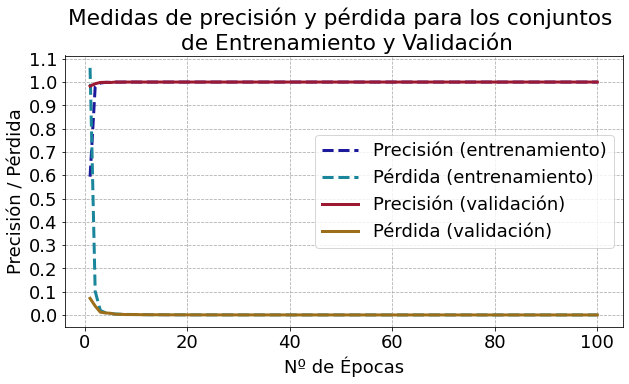

In [27]:
from matplotlib import rc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from numpy import arange

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(1,len(acc)+1,1)

font = {'size'   : 18}
rc('font', **font)
plt.figure(figsize=(10,5))
#plt.xticks(epochs)
plt.yticks(arange(0,max(max(loss),max(val_loss),1.)+.1,.1))
plt.plot ( epochs, acc, '#1d199c', label='Precisión (entrenamiento)', linewidth=3, linestyle='--')
plt.plot ( epochs, loss, '#19869c', label='Pérdida (entrenamiento)', linewidth=3, linestyle='--')
plt.plot ( epochs, val_acc,  '#9c1931', label='Precisión (validación)', linewidth=3)
plt.plot ( epochs, val_loss,  '#9c6e19', label='Pérdida (validación)', linewidth=3)

plt.title ('Medidas de precisión y pérdida para los conjuntos \n de Entrenamiento y Validación')
plt.ylabel('Precisión / Pérdida')
plt.xlabel('Nº de Épocas')

plt.legend()
plt.grid(b=None, which='major', axis='both', linestyle='--')

Ahora, se evalúa el modelo respecto al subconjunto de test. Esto sirve como validación final ya que son datos que el modelo no ha visto y que no han influido a la hora de tomar decisiones sobre los hiperparámetros de la red. Por ello, este conjunto se ha reservado para el final.

In [28]:
metrics_test = model.evaluate(
             test_set,
             batch_size=30,
             steps= test_set.n // batch_size,
             verbose=1,
             return_dict=True)

acc_test    = metrics_test['accuracy']
loss_test   = metrics_test['loss']

print(f"Precisión para el conjunto de Prueba: {acc_test}")
print(f"Pérdida para el conjunto de Prueba: {loss_test}")

120/120 [==============================] - 2s 18ms/step - loss: 2.6619e-04 - accuracy: 1.0000
Precisión para el conjunto de Prueba: 1.0
Pérdida para el conjunto de Prueba: 0.0002661898033693433


### Guardado del modelo
Si lo deseamos, se puede guardar el modelo ya entrenado en fichero un fichero .h5 para ser importado y utilizado para hacer nuevas predicciones.

In [11]:
#### Introducir nombre del archivo que se va a guardar.
nombreArchivo = 'carlosNet-no-aug-final'

model.save(str(nombreArchivo) + '.h5')

## CarlosNet (Con data augmentation)

### Aumento de los subconjuntos del dataset

En esta ocasión, no solo importaremos el conjunto de datos sino que le aplicaremos combinaciones de transformaciones aleatorias como se describe en los parámetros de la clase ImageDataGenerator. Se aplicará una combinación de las transformaciones: Espejo vertical y/o horizontal, rotación, desplazamiento vertical y/o horizontal, ampliación y/ó reducción. Se han escogido estos valores para evitar en lo posible que la mano no se salga de los bordes de la imagen.

Bien es cierto que para entrenar el modelo, solo haría falta hacer un aumento del subconjunto de entrenamiento, pues el objetivo es maximizar la precisión para los subconjuntos de validación y prueba tal y como se propocionan. Se hace este aumento para validación y prueba tan solo con propósitos de poder comparar el nivel de generalización que obtenemos de las redes al entrenar con y sin aumento.

Dado que el conjunto de entrenamiento es muy homogéneo, puede ser útil hacer aumento para demostrar que en caso de que unas imágenes nuevas a predecir, que sean levemente distintas que las del dataset, también se predicen correctamente.

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      rotation_range=90)

train_dir=f"{dataset_folder}/train"
test_dir=f"{dataset_folder}/test"
val_dir=f"{dataset_folder}/val"

aug_train_set = augmented_datagen.flow_from_directory(train_dir,
                  batch_size=30,
                  class_mode='categorical',
                  target_size=(128, 128),
                  color_mode="grayscale")

aug_test_set = augmented_datagen.flow_from_directory(test_dir,
                  batch_size=30,
                  class_mode = 'categorical',
                  target_size = (128, 128),
                  color_mode="grayscale")

aug_val_set = augmented_datagen.flow_from_directory(val_dir,
                  batch_size=30,
                  class_mode = 'categorical',
                  target_size = (128, 128),
                  color_mode="grayscale")

batch_size = 30
aug_steps_per_epoch = aug_train_set.n // batch_size
aug_validation_steps = aug_val_set.n // batch_size
print("Pasos por época: " + str(aug_steps_per_epoch) + "    Pasos de validación: " + str(aug_validation_steps))

Found 14400 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Pasos por época: 480    Pasos de validación: 120


### Estructura de la red

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import models

model2 = models.Sequential()
model2.add(layers.Conv2D(4,(3,3),activation='relu',input_shape=(128,128,1)))
model2.add(layers.MaxPooling2D((3, 3)))
model2.add(layers.Conv2D(8,(5,5),activation='relu'))
model2.add(layers.MaxPooling2D((3, 3)))
model2.add(layers.Conv2D(16, (7,7), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(6, activation='softmax'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 4)       40        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 42, 42, 4)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 38, 38, 8)         808       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 16)          6288      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)              

### Entrenamiento del modelo

Dado que ahora el subconjunto de entrenamiento tiene mucha más variabilidad (ha sido aumentado), se necesitan más épocas para que el modelo logre conseguir una precisión cercana a la obtenida para el subconjunto de entrenamiento como se proporciona.

Se ha usado un optimizador SGD con momento de nesterov que en nuestros experimentos ha demostrado acelerar bastante la convergencia hacia la red con mayor precisión.

Recordemos que el objetivo del modelo es predecir lo mejor posible para los subconjuntos de prueba y validación, tal y como están, sin aumento. Es por eso que comparamos la precisión la versión de los subconjuntos sin aumentos.

Posteriormente, a modo de orientación, también evaluaremos como sería el rendimiento si se aplicase aumento. Esto sería una forma de estimar que tan bien generalizan los modelos.

In [22]:
from tensorflow.keras.optimizers import SGD

sgd_optimizer= SGD(momentum=0.8,nesterov=True)

model2.compile(loss='categorical_crossentropy',
              optimizer=sgd_optimizer,
              metrics=['accuracy'])

history2 = model2.fit(
             aug_train_set,
             steps_per_epoch= aug_steps_per_epoch,
             epochs=30,
             validation_data=val_set,
             validation_steps= aug_validation_steps,
             verbose=2)

Epoch 1/30
480/480 - 30s - loss: 1.5521 - accuracy: 0.3044 - val_loss: 1.1946 - val_accuracy: 0.3822
Epoch 2/30
480/480 - 29s - loss: 1.0154 - accuracy: 0.5481 - val_loss: 0.5383 - val_accuracy: 0.7869
Epoch 3/30
480/480 - 29s - loss: 0.6037 - accuracy: 0.7508 - val_loss: 0.3547 - val_accuracy: 0.8764
Epoch 4/30
480/480 - 29s - loss: 0.4299 - accuracy: 0.8303 - val_loss: 0.2220 - val_accuracy: 0.9158
Epoch 5/30
480/480 - 29s - loss: 0.3489 - accuracy: 0.8701 - val_loss: 0.2209 - val_accuracy: 0.9128
Epoch 6/30
480/480 - 29s - loss: 0.3005 - accuracy: 0.8907 - val_loss: 0.1345 - val_accuracy: 0.9522
Epoch 7/30
480/480 - 29s - loss: 0.2865 - accuracy: 0.8974 - val_loss: 0.0940 - val_accuracy: 0.9731
Epoch 8/30
480/480 - 30s - loss: 0.2680 - accuracy: 0.9060 - val_loss: 0.3159 - val_accuracy: 0.8847
Epoch 9/30
480/480 - 29s - loss: 0.2410 - accuracy: 0.9174 - val_loss: 0.0684 - val_accuracy: 0.9761
Epoch 10/30
480/480 - 29s - loss: 0.2269 - accuracy: 0.9216 - val_loss: 0.1688 - val_accura

### Guardado del modelo (con data augmentation)
Si lo deseamos, se puede guardar el modelo ya entrenado en fichero un fichero .h5 para ser importado y utilizado para hacer nuevas predicciones.

In [31]:
#### Introducir nombre del archivo que se va a guardar.
nombreArchivo = 'carlosNet-aug-final'

model2.save(str(nombreArchivo) + '.h5')

### Evaluación del rendimiento del modelo

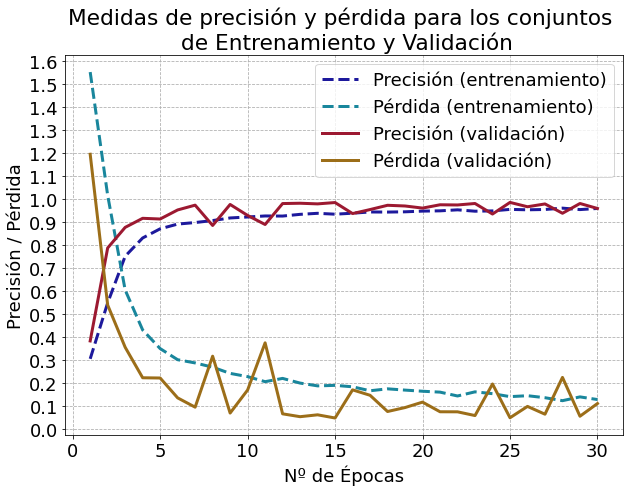

In [29]:
from matplotlib import rc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from numpy import arange

acc      = history2.history['accuracy']
val_acc  = history2.history['val_accuracy']
loss     = history2.history['loss']
val_loss = history2.history['val_loss']

epochs   = range(1,len(acc)+1,1)

font = {'size'   : 18}
rc('font', **font)
plt.figure(figsize=(10,7))
#plt.xticks(epochs)
plt.yticks(arange(0,max(max(loss),max(val_loss),1.)+.1,.1))
plt.plot ( epochs, acc, '#1d199c', label='Precisión (entrenamiento)', linewidth=3, linestyle='--')
plt.plot ( epochs, loss, '#19869c', label='Pérdida (entrenamiento)', linewidth=3, linestyle='--')
plt.plot ( epochs, val_acc,  '#9c1931', label='Precisión (validación)', linewidth=3)
plt.plot ( epochs, val_loss,  '#9c6e19', label='Pérdida (validación)', linewidth=3)

plt.title ('Medidas de precisión y pérdida para los conjuntos \n de Entrenamiento y Validación')
plt.ylabel('Precisión / Pérdida')
plt.xlabel('Nº de Épocas')

plt.legend()
plt.grid(b=None, which='major', axis='both', linestyle='--')

#### Evaluación del rendimiento para el subconjunto de Prueba (Sin data agmentation)

In [18]:
##### Evaluacion del modelo (Sin data agmentation).
metrics_test2 = model2.evaluate(
             test_set,
             batch_size=30,
             steps= test_set.n // batch_size,
             verbose=1,
             return_dict=True)

120/120 [==============================] - 2s 18ms/step - loss: 0.0647 - accuracy: 0.9767


### Comparación del nivel de generalización de los 2 modelos entrenados
La idea es evaluar el rendimiento de los dos modelos que se han entrenado: Con data augmentation y sin data augmentation.

La comparación la haremos evaluando esta vez respecto al mismo conjunto de prueba pero esta vez aumentado.

#### Generalización del modelo entrenado con data augmentation

In [19]:
##### Evaluacion del modelo.
metrics_test_aug2 = model2.evaluate(
             aug_test_set,
             batch_size=30,
             steps= aug_test_set.n // batch_size,
             verbose=1,
             return_dict=True)

120/120 [==============================] - 5s 45ms/step - loss: 0.1616 - accuracy: 0.9444


#### Generalización del modelo entrenado sin data augmentation

In [20]:
metrics_test_aug = model.evaluate(
             aug_test_set,
             batch_size=30,
             steps= aug_test_set.n // batch_size,
             verbose=1,
             return_dict=True)

120/120 [==============================] - 5s 45ms/step - loss: 14.4445 - accuracy: 0.1914


## Conclusión

Hemos observado que al entrenar la red sin data augmentation, se obtiene un rendimiento excelente al compararlo con los subconjuntos de validacón y prueba. Sin embargo, la convergencia es increiblemente rápida lo que puede ser un indicador de que la arquitectura del modelo puede asumir más conocimiento del que se proporciona en el dataset.

Vemos además como, al entrenar una red con la misma arquitectura con data augmentation, obtenemos resultados excelentes tanto para los conjuntos de prueba y validacion; aumentados y sin aumentar. Podríamos decir que en este caso se generaliza mucho mejor.

No podemos decir lo mismo del modelo que se ha entrenado sin data augmentation, pues se obtiene un rendimiento pésimo al evaluar el rendimiento respecto al subconjunto test con data augmentation.